# RTO Load-Price Analysis: Multi-Year Comparison

This notebook analyzes the relationship between electricity load and wholesale prices across different RTOs and years. For each RTO, we bin the data by total load and calculate median prices in each bin to compare how the load-price relationship has changed over time.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
from pathlib import Path

# Suppress specific warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning, message='.*mixed time zones.*')
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [7]:
# Load all RTO data files
data_dir = "rto_data"
data_files = glob.glob(f"{data_dir}/*_hourly_demand_and_price_*.csv")

print(f"Found {len(data_files)} data files:")
for file in sorted(data_files):
    print(f"  {os.path.basename(file)}")

# Parse file names to extract RTO and year information
rto_data = {}
for file in data_files:
    filename = os.path.basename(file)
    # Extract RTO and year from filename: rto_hourly_demand_and_price_year.csv
    parts = filename.replace('.csv', '').split('_')
    rto = parts[0].upper()
    year = int(parts[-1])
    
    if rto not in rto_data:
        rto_data[rto] = {}
    
    # Load the data - fix datetime parsing warning by specifying utc=True
    df = pd.read_csv(file)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    
    # Convert load from MW to GW
    df['load'] = df['load'] / 1000
    
    rto_data[rto][year] = df
    
    print(f"Loaded {rto} {year}: {len(df)} rows")

print(f"\nRTOs available: {list(rto_data.keys())}")
for rto, years in rto_data.items():
    print(f"  {rto}: {sorted(years.keys())}")


Found 13 data files:
  caiso_hourly_demand_and_price_2020.csv
  caiso_hourly_demand_and_price_2024.csv
  ercot_hourly_demand_and_price_2018.csv
  ercot_hourly_demand_and_price_2024.csv
  isone_hourly_demand_and_price_2018.csv
  isone_hourly_demand_and_price_2024.csv
  miso_hourly_demand_and_price_2024.csv
  nyiso_hourly_demand_and_price_2018.csv
  nyiso_hourly_demand_and_price_2024.csv
  pjm_hourly_demand_and_price_2018.csv
  pjm_hourly_demand_and_price_2024.csv
  spp_hourly_demand_and_price_2018.csv
  spp_hourly_demand_and_price_2024.csv
Loaded CAISO 2024: 8760 rows
Loaded SPP 2024: 8760 rows
Loaded NYISO 2018: 8731 rows
Loaded SPP 2018: 8736 rows
Loaded NYISO 2024: 8760 rows
Loaded CAISO 2020: 8760 rows
Loaded ISONE 2024: 8760 rows
Loaded ISONE 2018: 8736 rows
Loaded MISO 2024: 8760 rows
Loaded PJM 2024: 8760 rows
Loaded PJM 2018: 8736 rows
Loaded ERCOT 2018: 8736 rows
Loaded ERCOT 2024: 8760 rows

RTOs available: ['CAISO', 'SPP', 'NYISO', 'ISONE', 'MISO', 'PJM', 'ERCOT']
  CAISO: [2

In [8]:
def bin_load_and_calculate_median_price(df, bin_width=2.5):
    """
    Bin the data by load and calculate median price for each bin
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'load' and 'price' columns (load in GW)
    bin_width : float
        Width of load bins in GW (default: 2.5 GW)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with load bin midpoints and median prices
    """
    # Remove any NaN values - create explicit copy to avoid SettingWithCopyWarning
    df_clean = df.dropna(subset=['load', 'price']).copy()
    
    if len(df_clean) == 0:
        return pd.DataFrame(columns=['load_midpoint', 'median_price', 'count'])
    
    # Create load bins
    min_load = df_clean['load'].min()
    max_load = df_clean['load'].max()
    
    # Create bins from min to max load
    bins = np.arange(min_load - (min_load % bin_width), 
                     max_load + bin_width, 
                     bin_width)
    
    # Bin the data - now safe to assign since we have a copy
    df_clean['load_bin'] = pd.cut(df_clean['load'], bins=bins, right=False)
    
    # Calculate median price and count for each bin
    binned_data = df_clean.groupby('load_bin', observed=True).agg({
        'price': ['median', 'count']
    }).reset_index()
    
    # Flatten column names
    binned_data.columns = ['load_bin', 'median_price', 'count']
    
    # Calculate bin midpoints
    binned_data['load_midpoint'] = binned_data['load_bin'].apply(lambda x: x.mid)
    
    # Filter out bins with very few data points (less than 5)
    binned_data = binned_data[binned_data['count'] >= 5]
    
    return binned_data[['load_midpoint', 'median_price', 'count']].sort_values('load_midpoint')

# Test the function with one dataset
test_rto = list(rto_data.keys())[0]
test_year = list(rto_data[test_rto].keys())[0]
test_df = rto_data[test_rto][test_year]

test_result = bin_load_and_calculate_median_price(test_df)
print(f"Test with {test_rto} {test_year}:")
print(f"  Original data: {len(test_df)} rows")
print(f"  Binned data: {len(test_result)} bins")
print(f"  Load range: {test_result['load_midpoint'].min():.1f} - {test_result['load_midpoint'].max():.1f} GW")
print(f"  Price range: ${test_result['median_price'].min():.2f} - ${test_result['median_price'].max():.2f}/MWh")


Test with CAISO 2024:
  Original data: 8760 rows
  Binned data: 15 bins
  Load range: 11.2 - 46.2 GW
  Price range: $-33.37 - $90.19/MWh


In [9]:
# Process all RTO data and create binned datasets
binned_data = {}

for rto, years_data in rto_data.items():
    binned_data[rto] = {}
    print(f"\nProcessing {rto}:")
    
    for year, df in years_data.items():
        binned_df = bin_load_and_calculate_median_price(df)
        binned_data[rto][year] = binned_df
        print(f"  {year}: {len(binned_df)} bins (load range: {binned_df['load_midpoint'].min():.1f}-{binned_df['load_midpoint'].max():.1f} GW)")

# Identify RTOs with multiple years for comparison
multi_year_rtos = {rto: years for rto, years in binned_data.items() if len(years) > 1}
single_year_rtos = {rto: years for rto, years in binned_data.items() if len(years) == 1}

print(f"\nRTOs with multiple years (for comparison): {list(multi_year_rtos.keys())}")
print(f"RTOs with single year: {list(single_year_rtos.keys())}")

# Count total RTOs for subplot layout
total_rtos = len(binned_data)
print(f"\nTotal RTOs to plot: {total_rtos}")



Processing CAISO:
  2024: 15 bins (load range: 11.2-46.2 GW)
  2020: 13 bins (load range: 16.2-46.2 GW)

Processing SPP:
  2024: 13 bins (load range: 23.8-53.8 GW)
  2018: 12 bins (load range: 21.2-48.8 GW)

Processing NYISO:
  2018: 9 bins (load range: 11.2-31.2 GW)
  2024: 8 bins (load range: 11.2-28.8 GW)

Processing ISONE:
  2024: 8 bins (load range: 6.2-23.8 GW)
  2018: 8 bins (load range: 6.2-23.8 GW)

Processing MISO:
  2024: 26 bins (load range: 53.8-116.2 GW)

Processing PJM:
  2024: 36 bins (load range: 63.8-151.2 GW)
  2018: 36 bins (load range: 66.2-153.8 GW)

Processing ERCOT:
  2018: 19 bins (load range: 28.8-73.8 GW)
  2024: 20 bins (load range: 36.2-83.8 GW)

RTOs with multiple years (for comparison): ['CAISO', 'SPP', 'NYISO', 'ISONE', 'PJM', 'ERCOT']
RTOs with single year: ['MISO']

Total RTOs to plot: 7


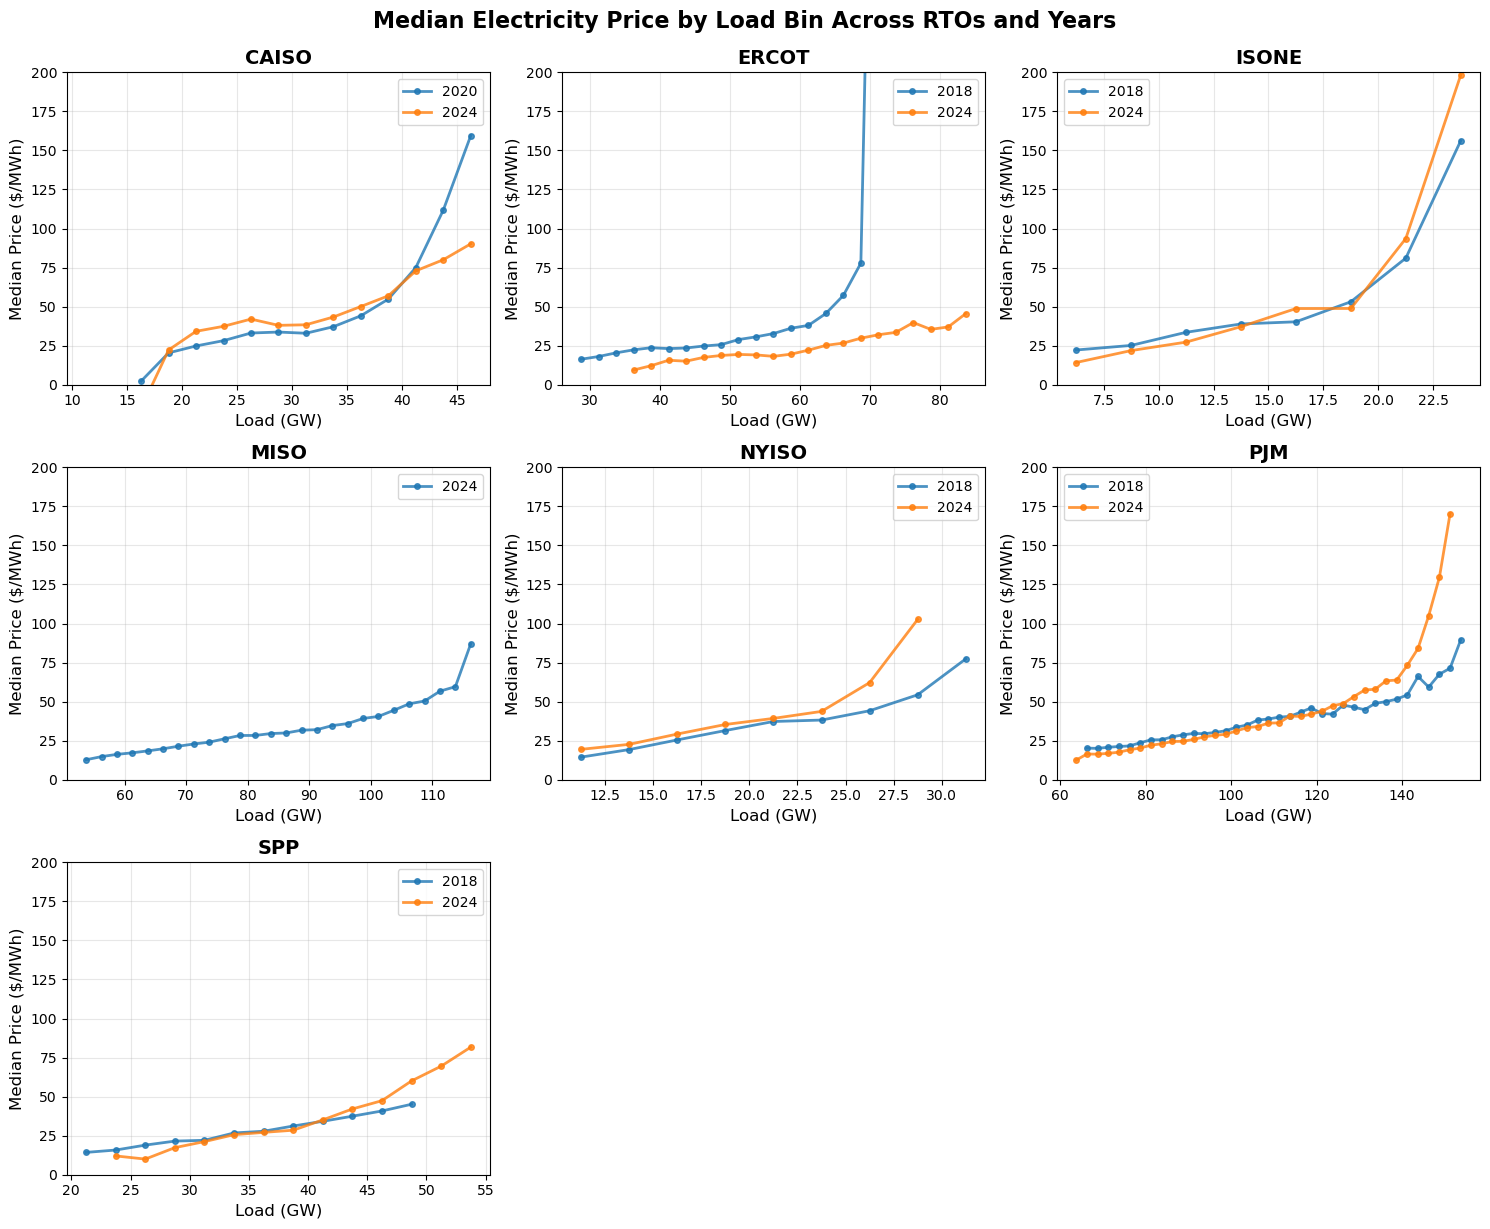

Plot saved as 'rto_data/plots/multi_rto_load_price_comparison.png'


<Figure size 640x480 with 0 Axes>

In [10]:
# Create multi-panel plot
# Calculate subplot layout (prefer wider than tall)
n_rtos = len(binned_data)
if n_rtos <= 3:
    n_cols = n_rtos
    n_rows = 1
elif n_rtos <= 6:
    n_cols = 3
    n_rows = 2
elif n_rtos <= 9:
    n_cols = 3
    n_rows = 3
else:
    n_cols = 4
    n_rows = (n_rtos + 3) // 4

# Create the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Handle case where we have only one subplot
if n_rtos == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes if n_cols > 1 else [axes]
else:
    axes = axes.flatten()

# Color palette for years
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plot each RTO
for idx, (rto, years_data) in enumerate(sorted(binned_data.items())):
    ax = axes[idx]
    
    # Plot each year for this RTO
    for year_idx, (year, binned_df) in enumerate(sorted(years_data.items())):
        if len(binned_df) > 0:
            ax.plot(binned_df['load_midpoint'], binned_df['median_price'], 
                   marker='o', linewidth=2, markersize=4,
                   color=colors[year_idx % len(colors)],
                   label=f'{year}', alpha=0.8)
    
    # Customize subplot
    ax.set_title(f'{rto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Load (GW)', fontsize=12)
    ax.set_ylabel('Median Price ($/MWh)', fontsize=12)
    ax.set_ylim(0,200)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

# Hide empty subplots
for idx in range(n_rtos, len(axes)):
    axes[idx].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.suptitle('Median Electricity Price by Load Bin Across RTOs and Years', 
             fontsize=16, fontweight='bold', y=1.02)

# Show the plot
plt.show()

# Save the plot
plt.savefig('rto_data/plots/multi_rto_load_price_comparison.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print("Plot saved as 'rto_data/plots/multi_rto_load_price_comparison.png'")


In [16]:
# Create the same analysis but using net load instead of total load
# Net load = Total load - Renewable generation (solar, wind, etc.)

def bin_net_load_and_calculate_median_price(df, bin_width=2.5):
    """
    Bin the data by net load and calculate median price for each bin
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'net_load' and 'price' columns (net_load in GW)
    bin_width : float
        Width of load bins in GW (default: 2.5 GW)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with net load bin midpoints and median prices
    """
    # Remove any NaN values - create explicit copy to avoid SettingWithCopyWarning
    df_clean = df.dropna(subset=['net_load', 'price']).copy()
    
    if len(df_clean) == 0:
        return pd.DataFrame(columns=['net_load_midpoint', 'median_price', 'count'])
    
    # Create net load bins
    min_load = df_clean['net_load'].min()
    max_load = df_clean['net_load'].max()
    
    # Create bins from min to max net load
    bins = np.arange(min_load - (min_load % bin_width), 
                     max_load + bin_width, 
                     bin_width)
    
    # Bin the data - now safe to assign since we have a copy
    df_clean['net_load_bin'] = pd.cut(df_clean['net_load'], bins=bins, right=False)
    
    # Calculate median price and count for each bin
    binned_data = df_clean.groupby('net_load_bin', observed=True).agg({
        'price': ['median', 'count']
    }).reset_index()
    
    # Flatten column names
    binned_data.columns = ['net_load_bin', 'median_price', 'count']
    
    # Calculate bin midpoints
    binned_data['net_load_midpoint'] = binned_data['net_load_bin'].apply(lambda x: x.mid)
    
    # Filter out bins with very few data points (less than 5)
    binned_data = binned_data[binned_data['count'] >= 5]
    
    return binned_data[['net_load_midpoint', 'median_price', 'count']].sort_values('net_load_midpoint')

# Process all RTO data and create binned datasets using net load
binned_net_load_data = {}

print("Processing net load data for all RTOs:")
for rto, years_data in rto_data.items():
    binned_net_load_data[rto] = {}
    print(f"\nProcessing {rto}:")
    
    for year, df in years_data.items():
        # Check if net_load column exists
        if 'net_load' in df.columns:
            # Convert net_load from MW to GW (if not already converted)
            if df['net_load'].max() > 1000:  # Assume if max > 1000, it's in MW
                df['net_load'] = df['net_load'] / 1000
            
            binned_df = bin_net_load_and_calculate_median_price(df)
            binned_net_load_data[rto][year] = binned_df
            print(f"  {year}: {len(binned_df)} bins (net load range: {binned_df['net_load_midpoint'].min():.1f}-{binned_df['net_load_midpoint'].max():.1f} GW)")
        else:
            print(f"  {year}: No net_load data available")
            binned_net_load_data[rto][year] = pd.DataFrame()

print(f"\nRTOs with net load data: {[rto for rto, years in binned_net_load_data.items() if any(len(df) > 0 for df in years.values())]}")


Processing net load data for all RTOs:

Processing CAISO:
  2024: 19 bins (net load range: -3.8-41.2 GW)
  2020: 15 bins (net load range: 6.2-41.2 GW)

Processing SPP:
  2024: 17 bins (net load range: 6.2-46.2 GW)
  2018: 16 bins (net load range: 8.8-46.2 GW)

Processing NYISO:
  2018: 9 bins (net load range: 11.2-31.2 GW)
  2024: 8 bins (net load range: 11.2-28.8 GW)

Processing ISONE:
  2024: 8 bins (net load range: 6.2-23.8 GW)
  2018: 0 bins (net load range: nan-nan GW)

Processing MISO:
  2024: 30 bins (net load range: 36.2-108.8 GW)

Processing PJM:
  2024: 36 bins (net load range: 56.2-143.8 GW)
  2018: 0 bins (net load range: nan-nan GW)

Processing ERCOT:
  2018: 22 bins (net load range: 13.8-66.2 GW)
  2024: 24 bins (net load range: 11.2-68.8 GW)

RTOs with net load data: ['CAISO', 'SPP', 'NYISO', 'ISONE', 'MISO', 'PJM', 'ERCOT']


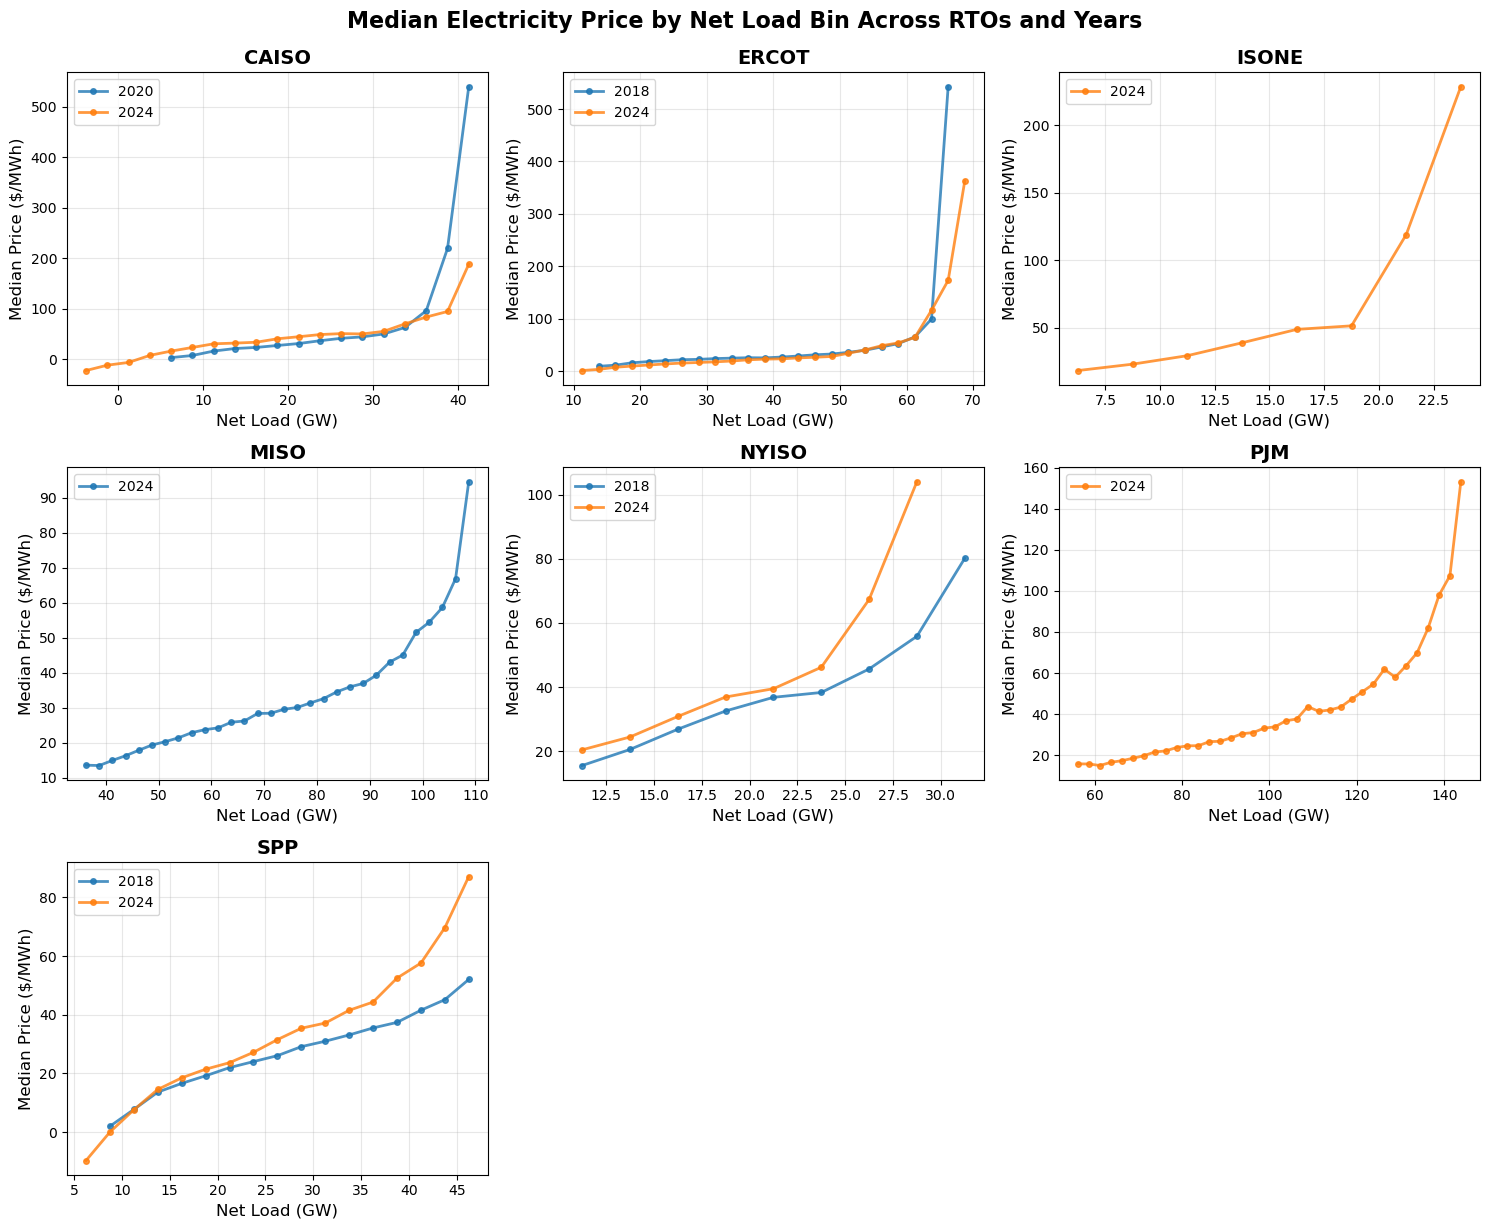

Plot saved as 'rto_data/plots/multi_rto_net_load_price_comparison.png'

Net Load Analysis completed for 7 RTOs


<Figure size 640x480 with 0 Axes>

In [17]:
# Create multi-panel plot for Net Load vs Price
# Filter out RTOs with no net load data
rtos_with_net_load = {rto: years for rto, years in binned_net_load_data.items() 
                      if any(len(df) > 0 for df in years.values())}

if len(rtos_with_net_load) == 0:
    print("No RTOs have net load data available.")
else:
    # Calculate subplot layout (prefer wider than tall)
    n_rtos = len(rtos_with_net_load)
    if n_rtos <= 3:
        n_cols = n_rtos
        n_rows = 1
    elif n_rtos <= 6:
        n_cols = 3
        n_rows = 2
    elif n_rtos <= 9:
        n_cols = 3
        n_rows = 3
    else:
        n_cols = 4
        n_rows = (n_rtos + 3) // 4

    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

    # Handle case where we have only one subplot
    if n_rtos == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()

    # Color palette for years
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Plot each RTO
    for idx, (rto, years_data) in enumerate(sorted(rtos_with_net_load.items())):
        ax = axes[idx]
        
        # Plot each year for this RTO
        for year_idx, (year, binned_df) in enumerate(sorted(years_data.items())):
            if len(binned_df) > 0:
                ax.plot(binned_df['net_load_midpoint'], binned_df['median_price'], 
                       marker='o', linewidth=2, markersize=4,
                       color=colors[year_idx % len(colors)],
                       label=f'{year}', alpha=0.8)
        
        # Customize subplot
        ax.set_title(f'{rto}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Net Load (GW)', fontsize=12)
        ax.set_ylabel('Median Price ($/MWh)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)

    # Hide empty subplots
    for idx in range(n_rtos, len(axes)):
        axes[idx].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle('Median Electricity Price by Net Load Bin Across RTOs and Years', 
                 fontsize=16, fontweight='bold', y=1.02)

    # Show the plot
    plt.show()

    # Save the plot
    plt.savefig('rto_data/plots/multi_rto_net_load_price_comparison.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    print("Plot saved as 'rto_data/plots/multi_rto_net_load_price_comparison.png'")
    
    print(f"\nNet Load Analysis completed for {n_rtos} RTOs")


In [11]:
# Create summary statistics table
summary_stats = []

for rto, years_data in sorted(binned_data.items()):
    for year, binned_df in sorted(years_data.items()):
        if len(binned_df) > 0:
            stats = {
                'RTO': rto,
                'Year': year,
                'Load_Range_GW': f"{binned_df['load_midpoint'].min():.1f} - {binned_df['load_midpoint'].max():.1f}",
                'Price_Range_$/MWh': f"{binned_df['median_price'].min():.1f} - {binned_df['median_price'].max():.1f}",
                'Avg_Price_$/MWh': f"{binned_df['median_price'].mean():.1f}",
                'Price_Volatility': f"{binned_df['median_price'].std():.1f}",
                'Number_of_Bins': len(binned_df)
            }
            summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print("Summary Statistics by RTO and Year:")
print("="*80)
print(summary_df.to_string(index=False))

# Calculate year-over-year changes for RTOs with multiple years
print("\n\nYear-over-Year Changes (for RTOs with multiple years):")
print("="*60)

for rto in multi_year_rtos:
    years = sorted(binned_data[rto].keys())
    if len(years) >= 2:
        print(f"\n{rto}:")
        for i in range(1, len(years)):
            earlier_year = years[i-1]
            later_year = years[i]
            
            earlier_data = binned_data[rto][earlier_year]
            later_data = binned_data[rto][later_year]
            
            if len(earlier_data) > 0 and len(later_data) > 0:
                earlier_avg_price = earlier_data['median_price'].mean()
                later_avg_price = later_data['median_price'].mean()
                price_change = ((later_avg_price - earlier_avg_price) / earlier_avg_price) * 100
                
                print(f"  {earlier_year} → {later_year}:")
                print(f"    Average price change: {price_change:+.1f}% (${earlier_avg_price:.1f} → ${later_avg_price:.1f}/MWh)")
                
                # Compare price volatility
                earlier_volatility = earlier_data['median_price'].std()
                later_volatility = later_data['median_price'].std()
                volatility_change = ((later_volatility - earlier_volatility) / earlier_volatility) * 100
                print(f"    Price volatility change: {volatility_change:+.1f}% (${earlier_volatility:.1f} → ${later_volatility:.1f} std dev)")


Summary Statistics by RTO and Year:
  RTO  Year Load_Range_GW Price_Range_$/MWh Avg_Price_$/MWh Price_Volatility  Number_of_Bins
CAISO  2020   16.2 - 46.2       2.3 - 159.5            50.6             42.6              13
CAISO  2024   11.2 - 46.2      -33.4 - 90.2            35.5             36.2              15
ERCOT  2018   28.8 - 73.8     16.3 - 1216.9           124.1            294.8              19
ERCOT  2024   36.2 - 83.8        9.4 - 45.5            24.6              9.9              20
ISONE  2018    6.2 - 23.8      22.2 - 156.2            56.3             44.4               8
ISONE  2024    6.2 - 23.8      14.2 - 198.3            61.2             60.5               8
 MISO  2024  53.8 - 116.2       12.8 - 87.1            33.5             16.8              26
NYISO  2018   11.2 - 31.2       14.5 - 77.4            38.0             19.2               9
NYISO  2024   11.2 - 28.8      19.5 - 102.6            44.3             27.1               8
  PJM  2018  66.2 - 153.8       20

## Key Insights

This analysis reveals several important patterns in electricity markets:

### Load-Price Relationships
- **Positive Correlation**: Most RTOs show a positive relationship between load and price, indicating that higher demand drives higher wholesale prices
- **Market Efficiency**: The strength of this relationship varies by RTO, reflecting different market structures and generation mixes

### Year-over-Year Changes
- **Price Evolution**: Comparing years shows how market dynamics have changed over time
- **Volatility Trends**: Changes in price volatility indicate evolving market conditions and generation mix changes

### RTO Characteristics
- **Scale Differences**: RTOs operate at very different scales (e.g., NYISO ~15-25 GW vs PJM ~70-130 GW)
- **Price Ranges**: Significant variation in price levels and volatility across regions
- **Market Maturity**: Different RTOs show different load-price relationship patterns

### Methodology Notes
- **Binning**: Data is binned by load in 2.5 GW increments to smooth out short-term volatility
- **Median Prices**: Using median rather than mean prices reduces the impact of extreme price spikes
- **Minimum Bin Size**: Only bins with 5+ data points are included to ensure statistical significance

### Fixed Issues
- **DateTime Warnings**: Fixed FutureWarning about mixed timezone parsing by specifying `utc=True`
- **DataFrame Warnings**: Fixed SettingWithCopyWarning by explicitly creating DataFrame copies
